In [1]:
%cd ../..

/home/eli/AnacondaProjects/epych


In [2]:
%env DASK_LOGGING__DISTRIBUTED=CRITICAL
%env SPYTMPDIR=/mnt/data/tmp_storage
%env SPYLOGLEVEL=CRITICAL
%env SPYPARLOGLEVEL=CRITICAL

env: DASK_LOGGING__DISTRIBUTED=CRITICAL
env: SPYTMPDIR=/mnt/data/tmp_storage
env: SPYLOGLEVEL=CRITICAL
env: SPYPARLOGLEVEL=CRITICAL


In [3]:
import collections
import functools
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import quantities as pq

import epych
from epych.statistics import alignment

[striatum:3339899] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.striatum.1000/jf.0/1806172160/shared_mem_cuda_pool.striatum could be created.
[striatum:3339899] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
ADAPTED_ONSET = pq.Quantity(-1.0) * pq.second
ADAPTED_OFFSET = pq.Quantity(-0.5) * pq.second
ODDBALL_ONSET = pq.Quantity(-1.9017372477960602e-14) * pq.second
ODDBALL_OFFSET = pq.Quantity(0.5004545430388676) * pq.second
OFFSET = pq.Quantity(0.25) * pq.second
EVENTS = {
    "Oddball": (ODDBALL_ONSET.magnitude, 'lightgreen'),
    "Offset": (ODDBALL_OFFSET.magnitude, 'red'),
}

In [7]:
CONDITIONS = ["lonaive", "go_gloexp", "go_seqctl", "lo_gloexp", "lo_rndctl", "igo_seqctl"]

In [8]:
area_titles = {
    "VISal": "AL",
    "VISam": "AM",
    "VISl": "LM",
    "VISp": "V1",
    "VISpm": "PM",
    "VISrl": "RL",
}
def stattitle(name, stat):
    if name in area_titles:
        return area_titles[name]
    return name
anatomical_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

In [9]:
def initialize_spectrum(key, signal, path=None):
    area = os.path.commonprefix([loc for loc in signal.channels.location])
    return epych.statistics.spectrum.Spectrogram(signal.df, signal.channels, signal.f0, chunk_trials=3, taper="hann", path=path + "/" + key)

In [10]:
spectrograms = {}

In [11]:
for cond in CONDITIONS:
    cond_path = "/mnt/data/000253/grand_hippocampal_spectrogram_downsample8_%s" % cond
    spectrograms[cond] = epych.statistic.Summary.unpickle(cond_path, epych.statistics.spectrum.Spectrogram)
    logging.info("Loaded LFP spectrograms across condition %s" % cond)

INFO:root:Loaded LFP spectrograms across condition lonaive
INFO:root:Loaded LFP spectrograms across condition go_gloexp
INFO:root:Loaded LFP spectrograms across condition go_seqctl
INFO:root:Loaded LFP spectrograms across condition lo_gloexp
INFO:root:Loaded LFP spectrograms across condition lo_rndctl
INFO:root:Loaded LFP spectrograms across condition igo_seqctl


In [12]:
PVALUE = 5e-2

In [13]:
CONTRASTS = [("go_contrast", "go_gloexp", "go_seqctl"), ("ssa", "lo_gloexp", "igo_seqctl"), ("dd", "lo_rndctl", "lonaive")]

In [14]:
CONTRAST_TITLES = {
    "go_contrast": "Global Oddball vs AAAA Control",
    "ssa": "Local Oddball vs BBBB Control",
    "dd": "AAAB Random Control vs AAAB Naive"
}
def contrast_stattitle(contrast, name, stat):
    return stattitle(name, stat) + (" (%s)" % CONTRAST_TITLES[contrast])

In [15]:
def initialize_grand_cluster_test(key, signals):
    return epych.statistics.grand.GrandNonparametricClusterTest(signals[0].num_channels, len(signals[0].times), alpha=PVALUE, partitions=1000)

In [16]:
contrasts = {}

In [17]:
def baselined_spectrogram(spectrogram):
    return spectrogram.result().baseline(-3.5 * pq.second, -3.0 * pq.second, decibels=True)

def spectrogram_4minus3(spectrogram):
    spectrogram = baselined_spectrogram(spectrogram)
    diff = spectrogram[(ODDBALL_ONSET - OFFSET).magnitude:(ODDBALL_OFFSET + OFFSET).magnitude] - spectrogram[(ADAPTED_ONSET - OFFSET).magnitude:(ADAPTED_OFFSET + OFFSET).magnitude]
    return diff.shift_timestamps(-OFFSET)

In [18]:
def area_name(probe, signals):
    return probe

In [19]:
for (name, condl, condr) in CONTRASTS:
    contrasts[name] = epych.statistic.Summary(area_name, initialize_grand_cluster_test)
    contrasts[name]._trials = spectrograms[condl]._trials
    contrast_signals = {k: (spectrogram_4minus3(spectrograms[condl].stats[k]), spectrogram_4minus3(spectrograms[condr].stats[k]))
                        for k in spectrograms[condl].stats.keys()}
    contrasts[name].calculate([contrast_signals])
    logging.info("Nonparametrically contrasted spectrograms for %s" % name)

INFO:root:Nonparametrically contrasted spectrograms for go_contrast
INFO:root:Nonparametrically contrasted spectrograms for ssa
INFO:root:Nonparametrically contrasted spectrograms for dd


In [20]:
for (name, _, _) in CONTRASTS:
    area_contrasts = contrasts[name].results()
    contrasts[name] = epych.recording.EvokedSampling(epych.recording.empty_intervals(), epych.recording.empty_trials(), epych.recording.default_units(), **{
        k: v['signal'].fmap(lambda data: data * v['mask']) for k, v in area_contrasts.items()
    })
    contrasts[name].pickle("/mnt/data/000253/hippocampal_spectrogram_contrasts_4-3_" + name + '_05')

In [21]:
CONTRAST_VMAXES = {
    "go_contrast": 0.5,
    "ssa": 0.5,
    "dd": 0.5,
}

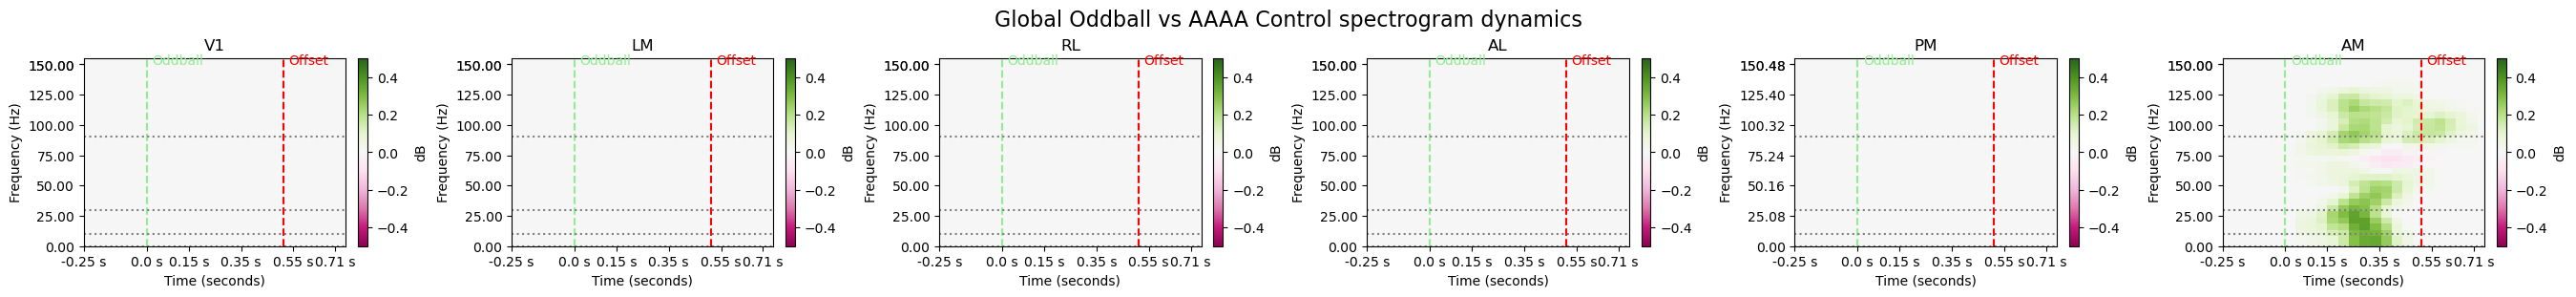

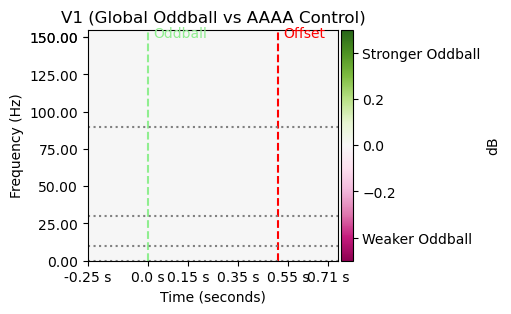

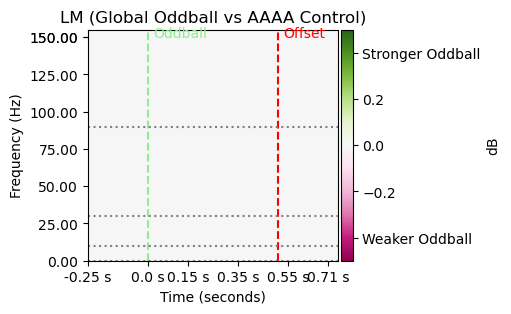

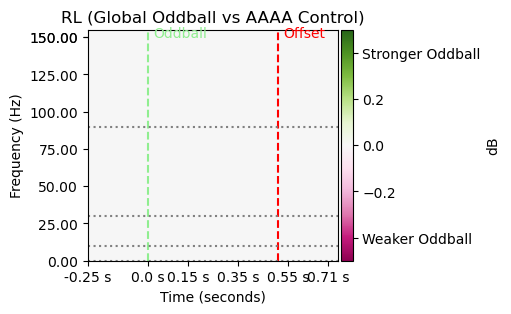

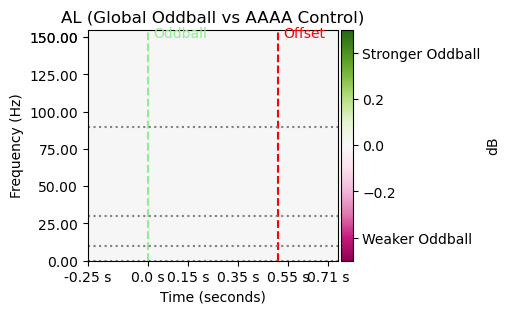

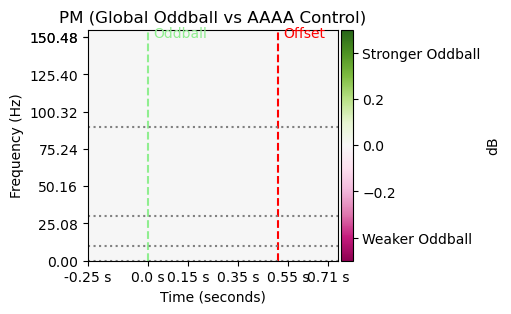

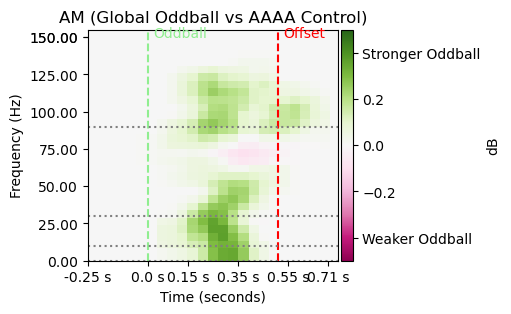

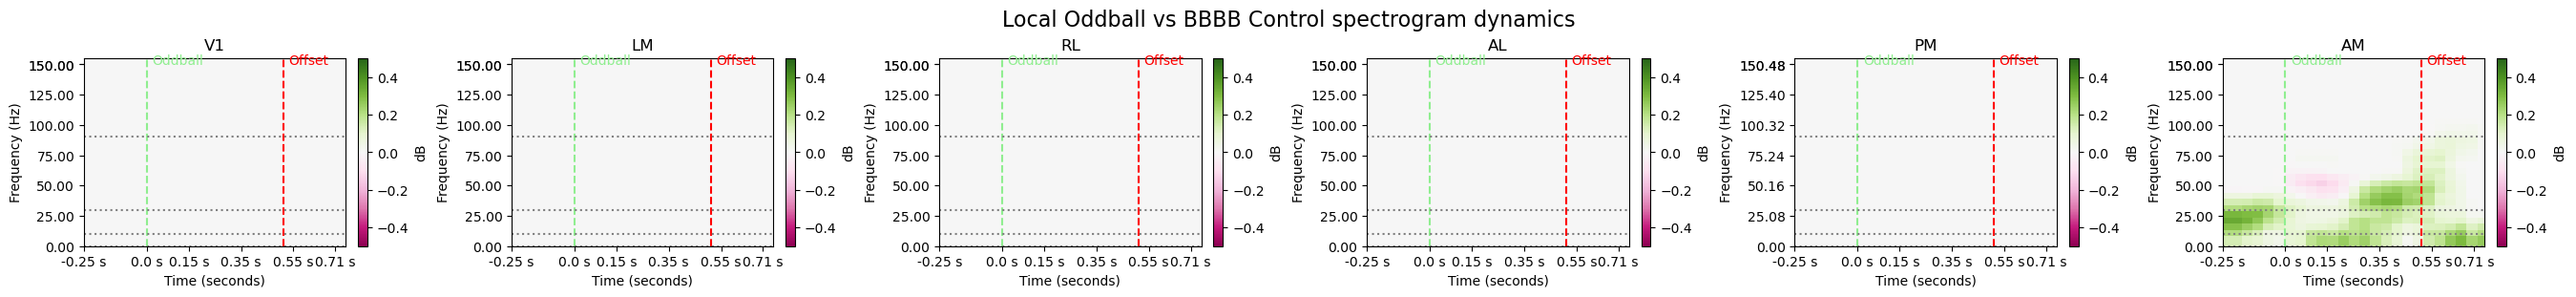

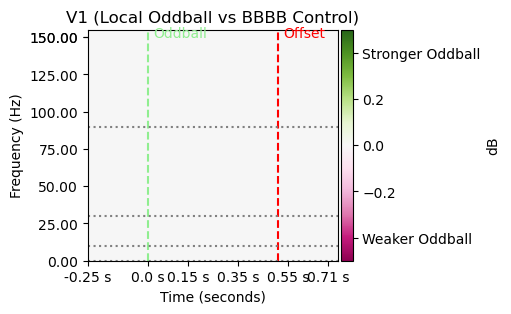

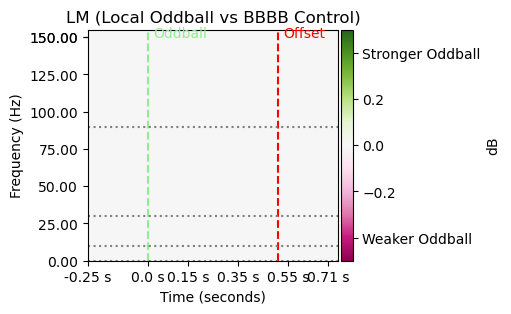

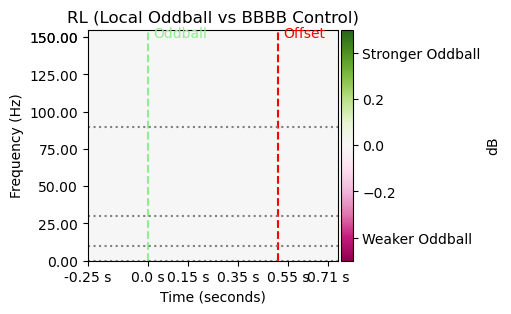

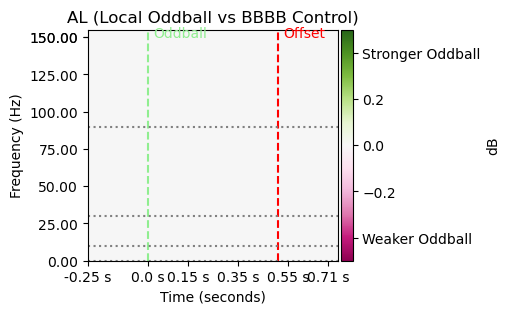

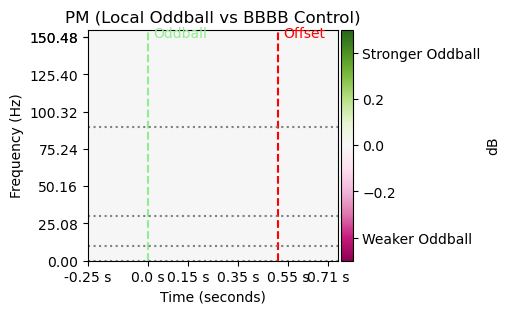

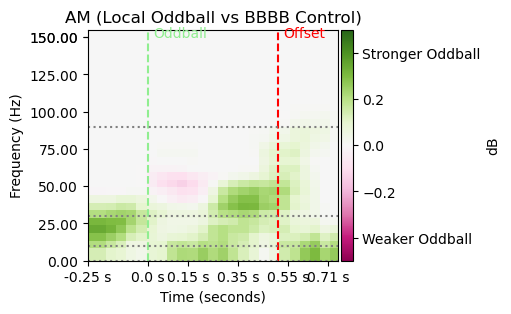

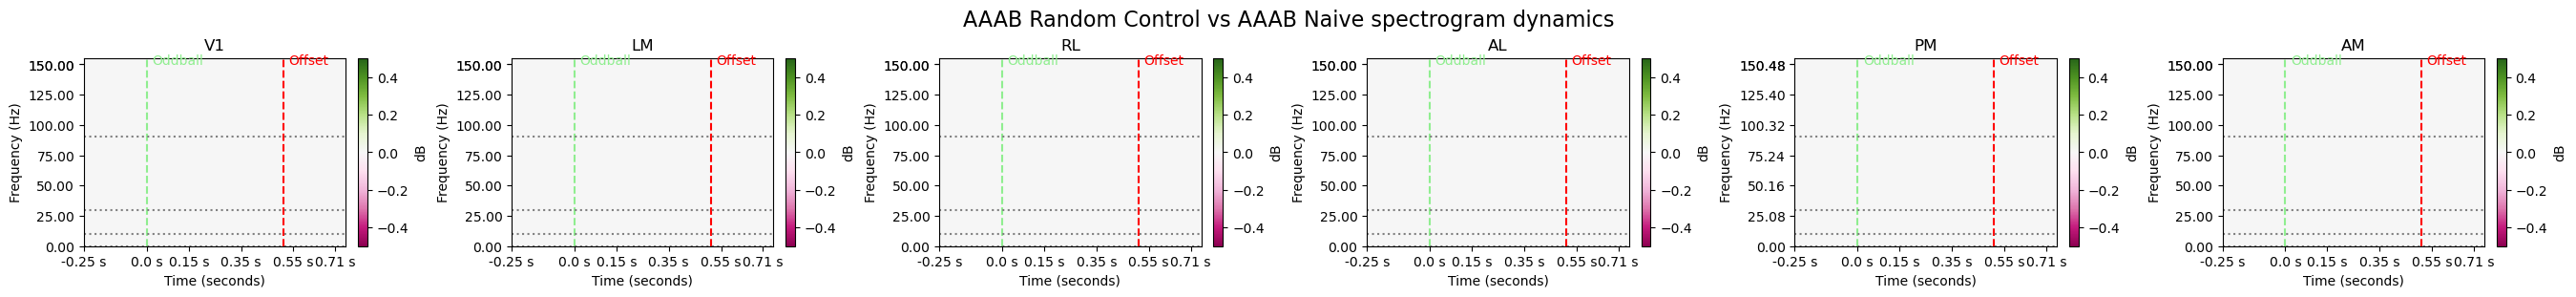

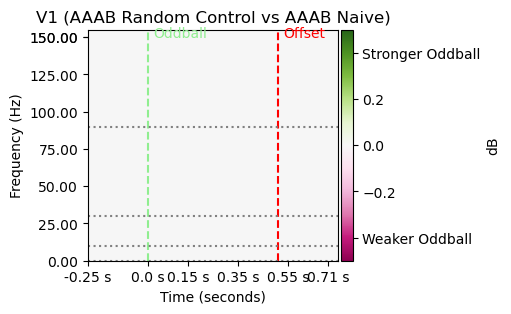

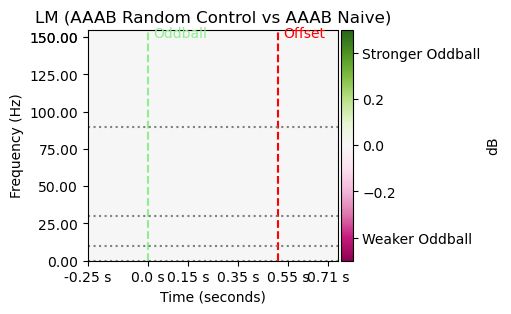

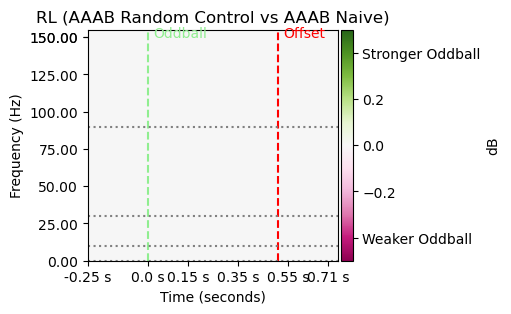

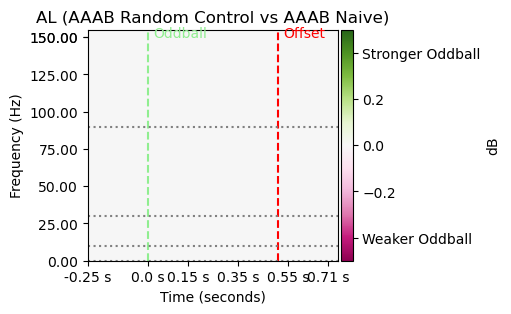

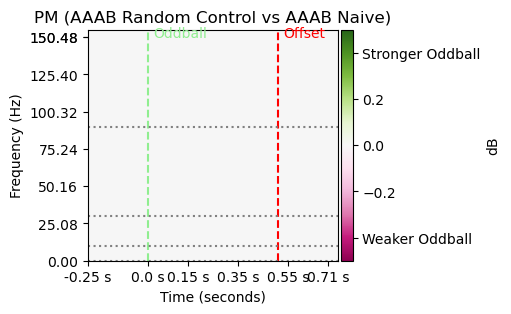

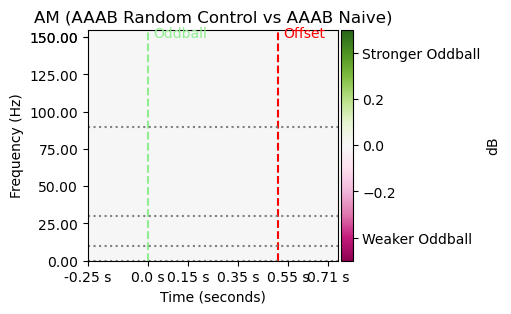

In [22]:
for (name, _, _) in CONTRASTS:
    contrast_title = functools.partial(contrast_stattitle, name)
    contrast_tfrs = contrasts[name]
    contrast_tfrs.plot(signals=anatomical_areas, sigtitle=stattitle, cmap='PiYG', vmax=CONTRAST_VMAXES[name], vmin=-CONTRAST_VMAXES[name], title=CONTRAST_TITLES[name] + " spectrogram dynamics",
                       figure="hippocampal_spectrogram_contrasts_4-3_%s_05.pdf" % name, **EVENTS)
    for area in anatomical_areas:
        os.makedirs("hippocampal_spectrogram_contrasts_4-3_%s_05/" % name, exist_ok=True)
        contrast_tfrs.signals[area].plot(title=contrast_title(area, contrasts[name].signals[area]), cmap='PiYG', vmax=CONTRAST_VMAXES[name], vmin=-CONTRAST_VMAXES[name],
                                         filename="hippocampal_spectrogram_contrasts_4-3_%s_05/%s.pdf" % (name, area), cbar_ends=("Stronger Oddball", "Weaker Oddball"), **EVENTS)